In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import utils
import som

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6735.43it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'sweet', 'pineapple', 'cherry', 'tropical', 'banana', 'fruity'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:
def do_train(config,verbose=False):
    shape = (config["width"], config["height"], len(all_notes_list))
    map = som.SOM(shape=shape,
              wrapping=som.WrappingMode.SPHERICAL,
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"])

    encodings = torch.stack([mol["encoding"] for mol in molecules])

    # steps = int(config["width"] * config["height"])
    # steps = config["width"], config["height"]
    steps = int((config["width"] * config["height"]))
    for i in tqdm.tqdm(range(steps),smoothing=0, disable=not verbose):
        map.update_batch(encodings)
        map.do_decay()

    print(map.gauss)
    return map

mapw = 15
maph = 12
step = .05

# In general, the larger the initial gauss, the longer the training will have to be
# Though using a stronger decay reduces this.
# A larger initial gauss does tend to lead to better distributions, though.

map = do_train({'width': mapw, 'height': maph, "gauss":min(mapw,maph)/2, "decay": .99, "onehot": True},verbose=True)
note_encodings = torch.stack([multi_hot([n]) for n,f in all_notes.most_common()])
all_activations = torch.stack([map.get_activations(enc) for enc in note_encodings])
print(all_activations.min(), all_activations.max())


100%|█████████████████████████████████████████| 180/180 [01:03<00:00,  2.82it/s]

0.9828478182485252
tensor(0.1353) tensor(0.9183)


fruity w/ (0.14,0.92)


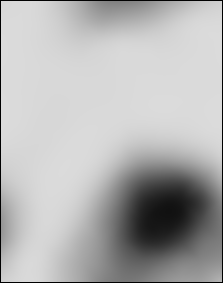

green w/ (0.14,0.87)


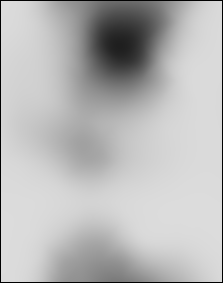

sweet w/ (0.14,0.88)


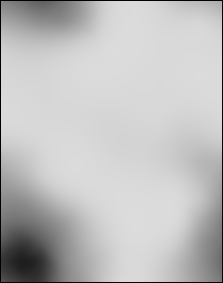

floral w/ (0.14,0.83)


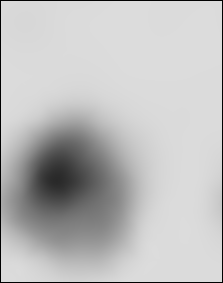

woody w/ (0.14,0.82)


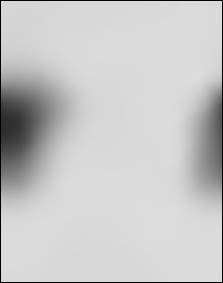

herbal w/ (0.14,0.74)


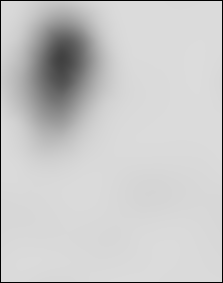

fresh w/ (0.14,0.39)


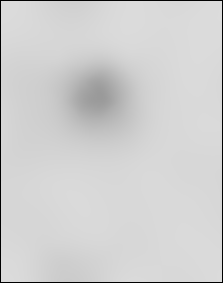

fatty w/ (0.14,0.67)


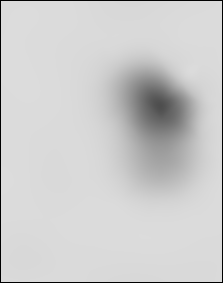

waxy w/ (0.14,0.47)


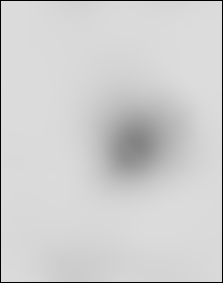

spicy w/ (0.14,0.52)


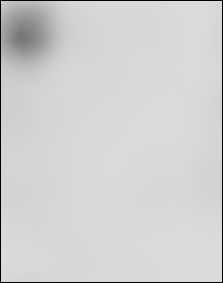

In [6]:
import PIL
def normalize(actvn,thresh=0):
    return torch.nn.functional.threshold(actvn,thresh,0)

def to_img_array(actvn,step,invert,thresh=0):
    _, rsz_actvn, rsz_shape = map.interpolate(actvn,step,method="cubic")
    mtrx = normalize(rsz_actvn,thresh).reshape(*rsz_shape).numpy()
    if invert:
        mtrx = 1-mtrx
    mtrx_norm = mtrx*255
    
    return clean(mtrx_norm)

def add_border(pil_img, border):
    width, height = pil_img.size
    new_width = width + 2*border
    new_height = height + 2*border
    result = PIL.Image.new(pil_img.mode, (new_width, new_height), 0)
    result.paste(pil_img, (border, border))
    return result

def clean(img_array):
    assert img_array.min() >= 0 and img_array.max() <= 255
    return img_array.astype('uint8')
    

def make_bw_pil(img_array, border=0):
    assert img_array.dtype=="uint8"
    assert img_array.min() >= 0 and img_array.max() <= 255
    w,h = img_array.shape
    img = PIL.Image.fromarray(img_array,mode="L")
    return add_border(img,border)

def make_empty_img_array(invert):
    return to_img_array(torch.full((map.width,map.height),amax),invert)

for n,f in all_notes.most_common(10):
    activations = map.get_activations(multi_hot([n]))
    norm = normalize(activations)
    print(f"{n} w/ ({norm.min().numpy():.2f},{norm.max().numpy():.2f})")
    display(make_bw_pil(to_img_array(activations,step=step,invert=True),1))


[11.  8.]


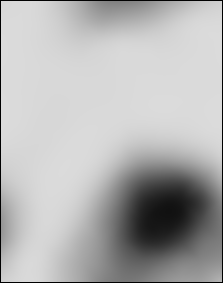

[2. 6.]


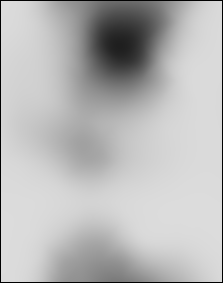

[13.  1.]


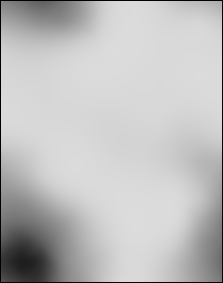

[[[215 219 131]
  [215 219 131]
  [215 219 130]]

 [[215 219 133]
  [215 219 132]
  [215 219 132]]

 [[215 219 135]
  [215 219 134]
  [215 219 133]]]


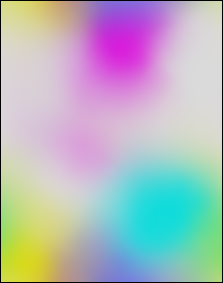

In [7]:
def make_rgb_pil(img_array,border=0):
    assert img_array.dtype=="uint8"
    assert img_array.min() >= 0 and img_array.max() <= 255
    w,h,c = img_array.shape
    assert c == 3
    img = PIL.Image.fromarray(img_array,mode="RGB")
    return add_border(img,border)

all_imgs = []
for n,f in all_notes.most_common(3):
    activations = map.get_activations(multi_hot([n]))
    bmu = map.get_bmu(multi_hot([n]))
    print(map.map_idx[bmu].numpy().squeeze())
    imgar = to_img_array(activations,step=step,invert=True,thresh=0)
    
    display(make_bw_pil(imgar,1))
    all_imgs.append(imgar)


# display(make_bw_pil(make_empty_img_array(False),30,1))
# all_imgs.append(make_empty_img_array(False))

rgb_img = np.stack(all_imgs,axis=-1)
print(rgb_img[:3,:3,:])

display(make_rgb_pil(rgb_img,1))

(281, 221, 3)


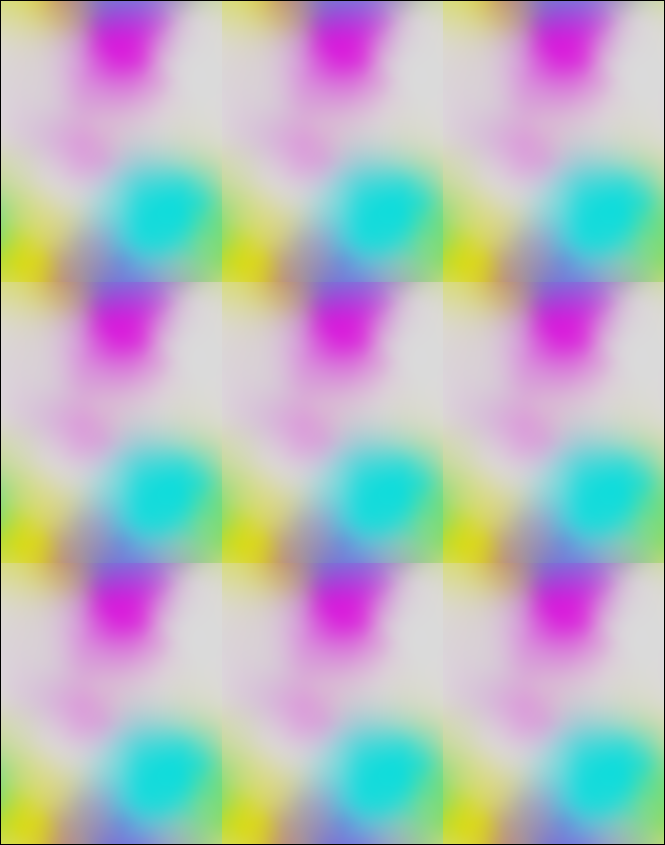

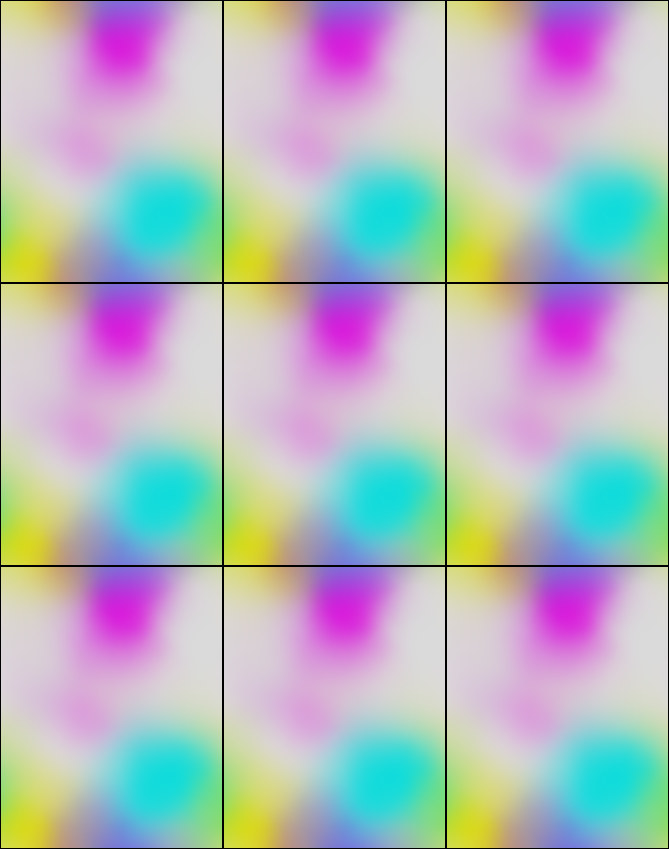

In [32]:
print(rgb_img.shape)
tiled = np.tile(rgb_img,(3,3,1))
display(make_rgb_pil(tiled,1))

# Attempting to tile the np arrays causes the border to be too thick.
def tile_pil(pil_img,tile_w,tile_h):
    w,h = pil_img.width, pil_img.height
    dst = PIL.Image.new(pil_img.mode, (w*tile_w, h*tile_h))
    for x in range(tile_w):
        for y in range(tile_h):
            dst.paste(pil_img,(x*w,y*h))
    return dst

display(tile_pil(make_rgb_pil(rgb_img,1),3,3))

tensor(160.) tensor(220.)
tensor(120.) tensor(40.)
tensor(20.) tensor(260.)


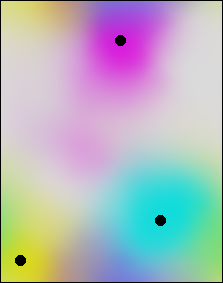

In [9]:
from PIL import ImageDraw

bmu_idxs = []
for n,f in all_notes.most_common(3):
    bmu_idxs.append(map.get_bmu_pos(multi_hot([n])).squeeze())

def draw_bmus(pil_img,step,bmu_idxs,r=5):
    dimg = ImageDraw.Draw(pil_img)
    for w,h in bmu_idxs:
        # This is inverted b/c I dontt know
        y0,x0 = (w)/step,(h)/step
        print(x0,y0)
        dimg.ellipse([x0-r,y0-r,x0+r,y0+r],fill="black")
    return dimg._image

display(draw_bmus(make_rgb_pil(rgb_img,1),step,bmu_idxs))
        


tensor(160.) tensor(220.)
tensor(120.) tensor(40.)
tensor(20.) tensor(260.)


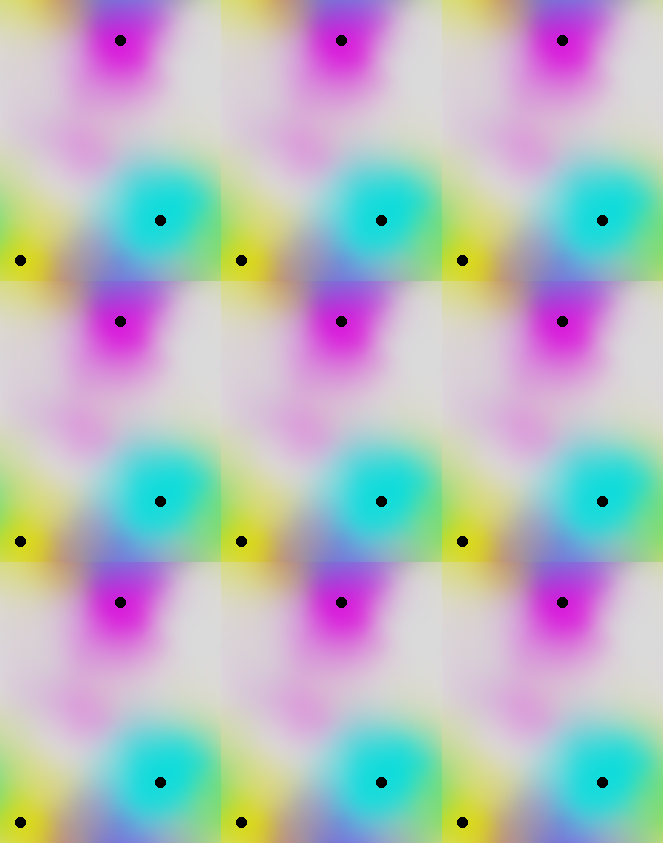

In [10]:
tile_pil(draw_bmus(make_rgb_pil(rgb_img,0),step,bmu_idxs),3,3)


fruity w/ (0.14,0.92)


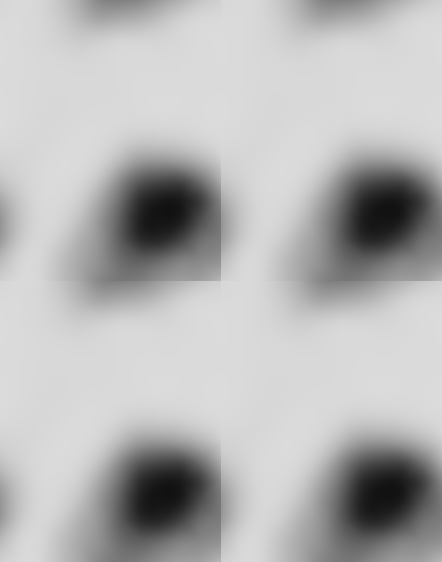

green w/ (0.14,0.87)


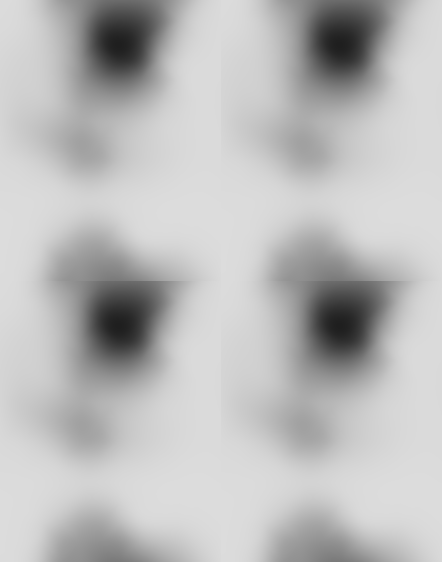

sweet w/ (0.14,0.88)


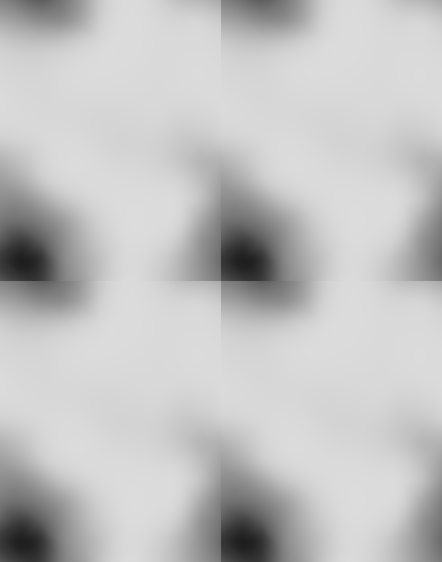

In [11]:
for n,f in all_notes.most_common(3):
    activations = map.get_activations(multi_hot([n]))
    norm = normalize(activations)
    print(f"{n} w/ ({norm.min().numpy():.2f},{norm.max().numpy():.2f})")
    display(tile_pil(make_bw_pil(to_img_array(activations,step=step,invert=True),0),2,2))


Next step is to try blending a variety of different maps
And then do the floodfill thing? IDK if it is worth it
* The reason I want to do floodfill is because it allows us to avoid the edge effect.
* We floodfill from the center cluster and that way it can flow to any of the 9 regions.
* We'd crop from there. 




In [12]:
palette = ["EF476F","FFD166","06D6A0","118AB2"]
layers = []
for n,f in all_notes.most_common(4):
    activations = map.get_activations(multi_hot([n]))
    layers.append(to_img_array(activations,step=step,invert=False))
layers = np.stack(layers,axis=-1)
layers.shape

(281, 221, 4)

In [13]:
def weight(rgb_color,weight):
    return tuple([int(c*weight) for c in rgb_color])

def draw_square(color):
    display(PIL.Image.new("RGB", (20, 20), color))

# Roughly the center
blend = layers[int(layers.shape[0]/2),int(layers.shape[1]/2),:]
color_array = []
for i,color in enumerate(palette):
    rgb_color = PIL.ImageColor.getrgb(f"#{color}")
    color_array.append(rgb_color)
    draw_square(rgb_color)
    draw_square(weight(rgb_color,blend[i]/255))

color_array = np.stack(color_array)
weights = blend/255
print(color_array,color_array.shape)
print(weights,weights.shape)
# np.matmul(blend/255,color_array)

# mixed_colors = np.sum([np.multiply(weights[i], color_array[i]) for i in range(len(color_array))],axis=0)

# colors_inverse = np.subtract((1, 1, 1), mixed_colors)

nc = np.zeros(color_array.shape)
for p in range(len(color_array)):
    for c in range(len(color_array[0])):
        # If the sum of weights is > 1 this could break
        nc[p,c] = color_array[p,c] * weights[p]

        
import matplotlib.colors as colors
# print(colors_inverse)
# print(colors.to_hex()

vals = (nc.sum(axis=0)/weights.sum(axis=0))/255
colors_inverse = np.subtract((1, 1, 1), vals)
draw_square(colors.to_hex(vals))
draw_square(colors.to_hex(colors_inverse))

[[239  71 111]
 [255 209 102]
 [  6 214 160]
 [ 17 138 178]] (4, 3)
[0.16078431 0.27843137 0.16470588 0.32156863] (4,)


In [14]:
weighted_sum = np.multiply(color_array,np.expand_dims(weights,-1)).sum(axis=0) / weights.sum() / 255
# draw_square(colors.to_hex(nc.sum(axis=0)/255))
draw_square(colors.to_hex(1-weighted_sum))
draw_square(colors.to_hex(weighted_sum))

(281, 221, 4)
(281, 221, 4) 0.13333333333333333 0.9294117647058824
(281, 221, 3) 60.46470588235294 202.86094674556213


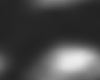

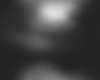

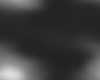

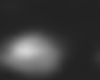

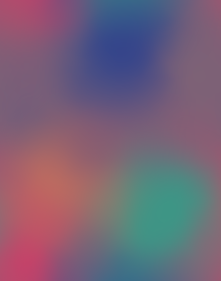

In [15]:
print(layers.shape)
layer_weights = layers.astype(float)/255
# Expect between 0 and 1 (where 1 is the high blend).
# This will break if we have white colors with weights.sum() > 1

print(layer_weights.shape,layer_weights.min(),layer_weights.max())
# No need to multiply by (layer_weights.sum(axis=-1,keepdims=True))
layer_color = np.matmul(layer_weights,color_array) / (layer_weights.sum(axis=-1,keepdims=True))
layer_color = np.nan_to_num(layer_color,0)
print(layer_color.shape,layer_color.min(),layer_color.max())
layer_color = layer_color.astype('uint8')
for l in range(layers.shape[-1]):
    display(make_bw_pil(layers[...,l]).resize((5*20,4*20),resample=PIL.Image.Resampling.NEAREST))
display(make_rgb_pil(255-layer_color))


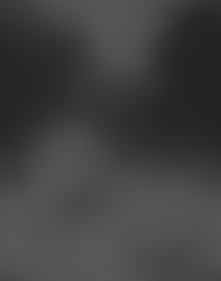

In [16]:
display(make_bw_pil(clean(layer_weights.mean(axis=-1)*255)))

(281, 221, 3) 60.46470588235294 202.86094674556213


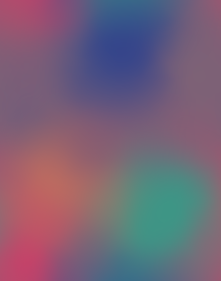

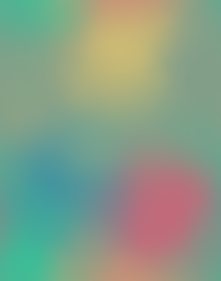

In [17]:
layer_color = np.matmul(layer_weights,color_array) / (layer_weights.sum(axis=-1,keepdims=True))
layer_color = np.nan_to_num(layer_color,0)
print(layer_color.shape,layer_color.min(),layer_color.max())
layer_color = clean(layer_color)
display(make_rgb_pil(255-layer_color))
display(make_rgb_pil(layer_color))

0.13333333333333333 0.9294117647058824
False


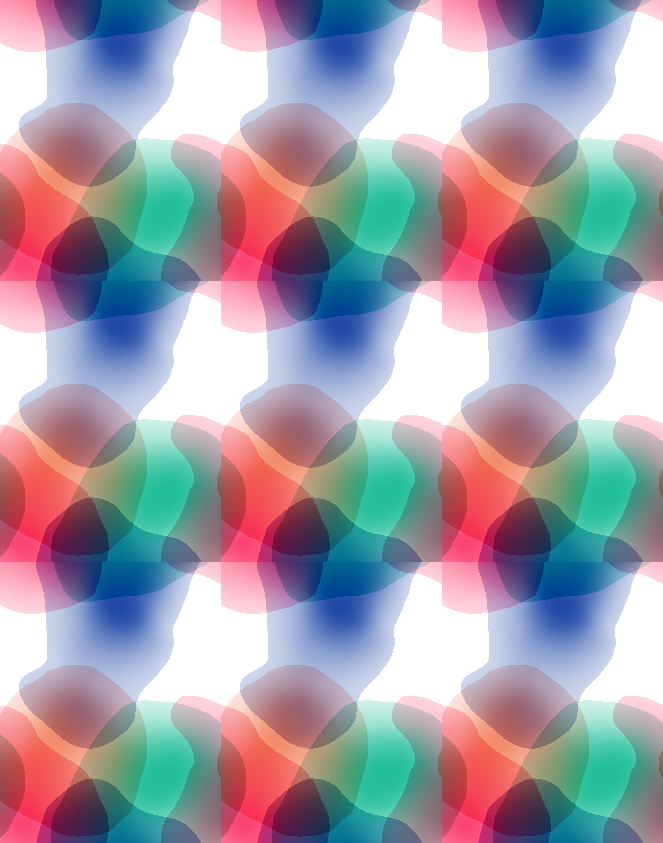

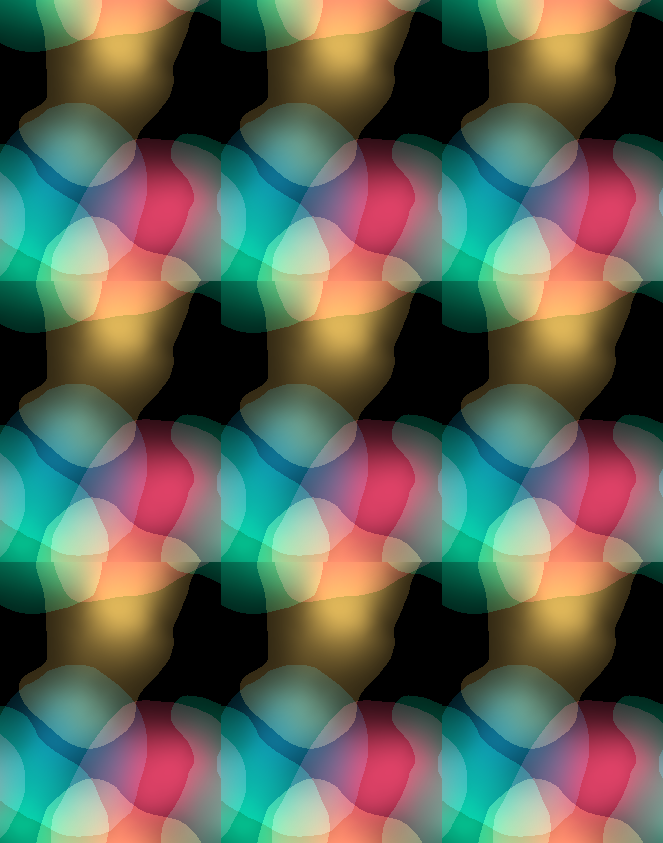

In [38]:
print(layer_weights.min(),layer_weights.max())
threshed_weights = np.where(layer_weights > .2, layer_weights, 0)
with np.errstate(divide='ignore', invalid='ignore'):
    layer_color = np.matmul(threshed_weights,color_array)

layer_color = np.nan_to_num(layer_color,1)
print(np.isnan(layer_color).any())
# print("LC",layer_color.shape,layer_color.min(),layer_color.max())
layer_color = clean(np.clip(layer_color,a_min=0,a_max=255))
# print("LC2",layer_color.shape,(255-layer_color).min(),(255-layer_color).max())
display(tile_pil(make_rgb_pil(255-layer_color),3,3))
display(tile_pil(make_rgb_pil(layer_color),3,3))

0.13333333333333333 0.9294117647058824
False


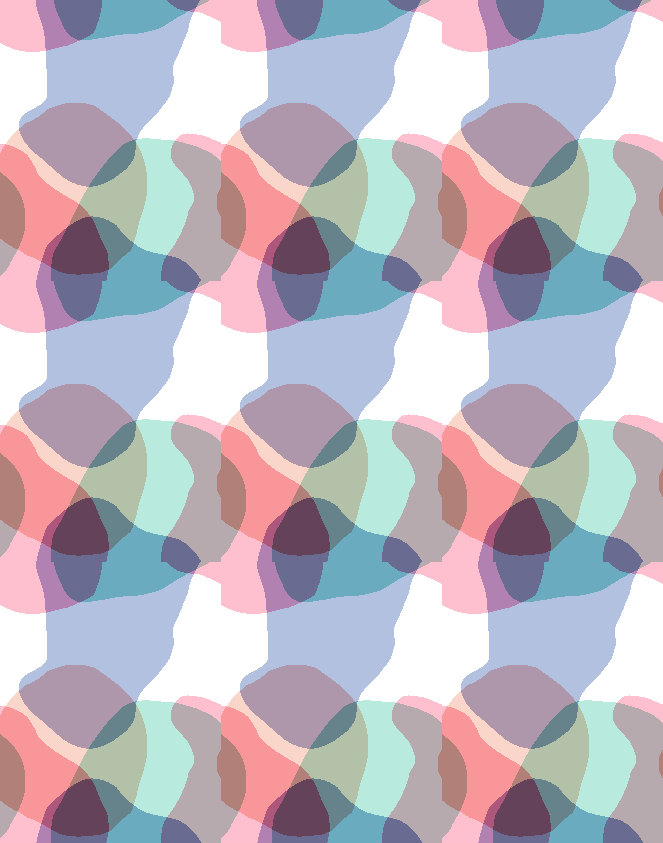

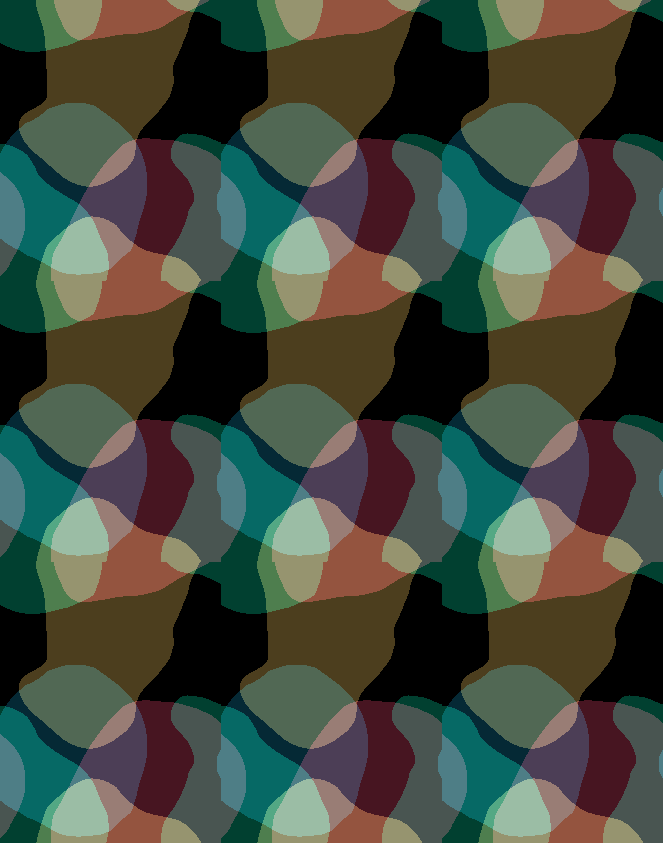

In [19]:
print(layer_weights.min(),layer_weights.max())
threshed_weights = np.where(layer_weights > .2, .3, 0)
with np.errstate(divide='ignore', invalid='ignore'):
    layer_color = np.matmul(threshed_weights,color_array)

layer_color = np.nan_to_num(layer_color,1)
print(np.isnan(layer_color).any())
# print("LC",layer_color.shape,layer_color.min(),layer_color.max())
layer_color = clean(np.clip(layer_color,a_min=0,a_max=255))
# print("LC2",layer_color.shape,(255-layer_color).min(),(255-layer_color).max())
display(tile_pil(make_rgb_pil(255-layer_color),3,3))
display(tile_pil(make_rgb_pil(layer_color),3,3))

0.13333333333333333 0.9294117647058824
(281, 221, 3) 0.0 189.6


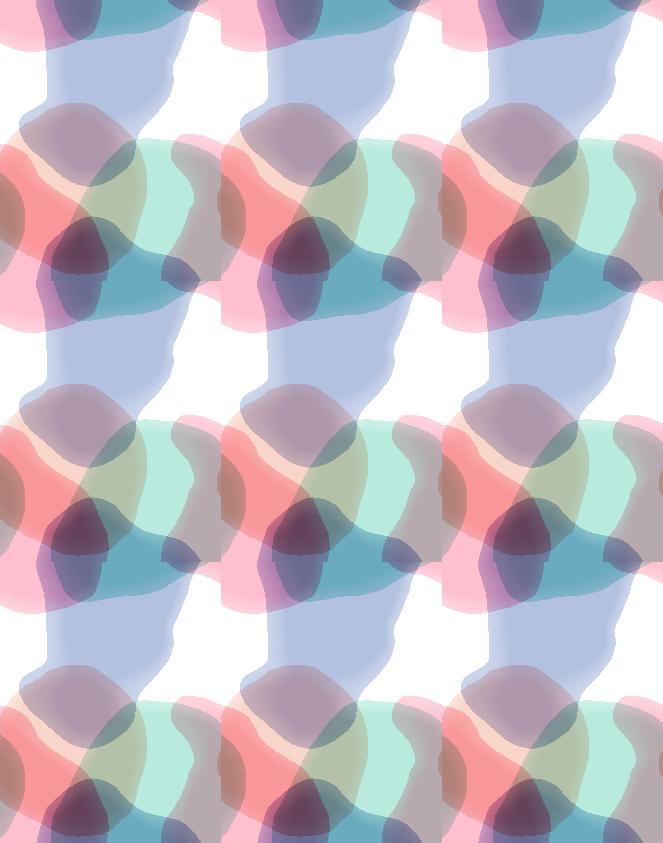

In [37]:
print(layer_weights.min(),layer_weights.max())
threshed_weights = np.where(layer_weights > .2, np.clip(layer_weights, a_min=0,a_max=.3), 0)
layer_color = np.matmul(threshed_weights,color_array) #/ (threshed_weights.sum(axis=-1,keepdims=True))
layer_color = np.nan_to_num(layer_color,0)
layer_color = np.clip(layer_color, a_min=0,a_max=255)
print(layer_color.shape,layer_color.min(),layer_color.max())
layer_color = clean(layer_color)
display(tile_pil(make_rgb_pil(255-layer_color),3,3))
